# Skill assessment - analysis
***

**Author**: Chus Casado Rodr√≠guez<br>
**Date**: 20-03-2023<br>


**Introduction**:<br>
In this notebook I will analyse the EFAS skill in predicting flood events in general, i.e., looking whether events where predicted at some point in time, regardless of neither the offset nor the duration of the event.

**Questions**:<br>

* [ ] Take into account the model spread?
* [ ] Aggregate results by river/administrative area? EFAS aims at alerting administrations about incoming events in there administrative area, shouldn't that aggregation be included in the results?
* [ ] Remove extremely bad performing stations.

**Pending tasks**:<br>

* [x] Weighting the model average by the Brier score?
* [x] Sort stations by catchment area (or other order)?
* [x] Persistence
* [ ] Analyse only the periods/stations close to an observed event and compute f1 for this extraction. Later on, on the complementary subset of data another metric must be computed to avoid false positives, p.e., false alarm ratio.



**Interesting links**<br>
[Evaluation metrics for imbalanced classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)<br>
[Cross entropy for machine learning](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)<br>
[Probability metrics for imbalanced classification](https://machinelearningmastery.com/probability-metrics-for-imbalanced-classification/)<br>
[ROC curves and precision-recall curves for imbalanced classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/)<br>
[Instructions for sending EFAS flood notifications](https://efascom.smhi.se/confluence/display/EDC/Instructions+for+sending%2C+upgrading+and+deactivating+EFAS+Flood+Notifications)

In [1]:
import os
import sys
import operator
import glob
import numpy as np
import pandas as pd
import xarray as xr
# import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime, timedelta
from tqdm import tqdm_notebook

path_root = os.getcwd()

import warnings
warnings.filterwarnings("ignore")

os.chdir('../py/')
from computations import *
from plots import *
os.chdir(path_root)

## 1 Configuration

### 1.1 Notification criteria

#### Probability threshold

In [2]:
# probability thresholds
thresholds = np.arange(.05, .96, .05).round(2)
# thresholds = np.round(sigmoid(np.linspace(-10, 10, 50)), 5)
probabilities = xr.DataArray(thresholds, dims=['probability'], coords={'probability': thresholds})

#### Persistence

A list of tuples with two values: the first value is the width of the window rolling sum, and the second value the minimum number of positives in that window so that a notification is raised.

In [3]:
persistence = [(1, 1), (2, 2), (2, 3), (3, 3), (2, 4), (3, 4)]#, (4, 4)]
persistence = {'/'.join([str(i) for i in pers]): pers for pers in persistence}

#### Leadtime

Notifications are only sent with a minimum leadtime (h).

In [4]:
min_leadtime = None

### 1.2 Output

In [97]:
name = 'EFAS'

# path where results will be saved
results_path = '../results/'
path_out = f'{results_path}skill/{name}/eventwise/no_resample_leadtime_60_inverse/'
if os.path.exists(path_out) is False:
    os.makedirs(path_out)

In [98]:
# coordinate reference system when plotting maps
proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52, false_easting=4321000, false_northing=3210000, globe=ccrs.Globe(ellipse='GRS80'))

## 2 Data

### 2.1 Stations

I load all the stations that where selected in a previous [notebook](3_0_select_stations.ipynb).

In [7]:
# load selected points for all the catchments
stations = pd.DataFrame()
catchments = []
folders = os.listdir(f'{results_path}reporting_points/')
for folder in folders:
    try:
        stn_cat = pd.read_csv(f'{results_path}reporting_points/{folder}/points_selected.csv', index_col='station_id')
        stations = pd.concat((stations, stn_cat))
        catchments.append(folder)
    except:
        continue
print('no. stations:\t\t\t{0}'.format(stations.shape[0]))

# remove unnecessary attributes
stations.drop(['rl1.5', 'rl2', 'rl10', 'rl20', 'rl50', 'rl100', 'rl200', 'rl500', 'strahler', 'pfafstetter', 'country'], axis=1, inplace=True)

# convert into integers
stations[['X', 'Y', 'area', 'rl5']] = stations[['X', 'Y', 'area', 'rl5']].astype(int)

no. stations:			900


### 2.2 Forecast: exceedance

I load the preprocessed forecast data. In a previous [notebook](4_0_forecast_exceedance_review.ipynb), the forecasted discharge was converted to probability of exceeding the 5-year return period threshold. The ouput of that process is a NetCDF file per station with the forecasted probability of exceedance. 

In [39]:
# find NetCDF files
path_forecast = '../data/exceedance/forecast/'
files = glob.glob(f'{path_forecast}*.nc')
files = [file for file in files if int(file.split(sep='\\')[-1].split('/')[-1].split('.')[0]) in stations.index]

# load data to a chunked DataArray
fore_exc = xr.open_mfdataset(files, combine='nested', concat_dim='id', chunks={'id': 1}).exceedance
fore_exc['id'] = fore_exc.id.astype(int)

# study period based on the extent of the forecast data
#start, end = [(fore_exc.forecast[i] + fore_exc.leadtime[i]).data for i in [0, -1]]
#start, end = [(date - np.datetime64('1970-01-01T01:00:00Z')) / np.timedelta64(1, 's') for date in [start, end]]
#start, end = [datetime.fromtimestamp(timestamp) for timestamp in [start, end]]

#print(f'Study period\nstart:\t{start}\nend:\t{end}')

##### Reformat data

To be able to compute skill in a simple manner, I need to reshape the exceedance forecast. Up until now, the exceedance forecast is saved in a matrix where the `forecast` is one dimension, and the `leadtime` is another dimension, in a way that there aren't missing values in the matrix. However, this shape is not convenient for comparing against the observed exceedances of the discharge threshold. Instead, I will reshape the original exceendance forecast into a new matrix in which a dimension named `datetime` represents actual date and time, and another dimension represents leadtime. In this way, a column in the matrix represents the same timestep and can be easily compared against observations. The drawback of this approach is that it will create missing values in the lower-left and upper-right corners of the matrix; therefore, I will remove these parts of the matrix (`trim=True`).

In [40]:
# reshape the DataArray of forecasted exceedance
pred = reshape_DataArray(fore_exc, trim=True, chunks={'id': 1})
del fore_exc

print(pred.dims)
print(pred.shape)

('id', 'model', 'leadtime', 'datetime')
(900, 4, 20, 2882)


### 2.3 Reanalysis: exceedance & events

I load the preprocessed reanalysis data. In a previous [notebook](2_2_reanalysis_preprocessing.ipynb), the reanalysis discharge data was preprocessed to create timeseries of exceedance over the 5-year return period threshold.

Out of the exceedance timeseries I calculate another timeseries of the onset of flood events.

no. events:			526
no. stations with events:	322


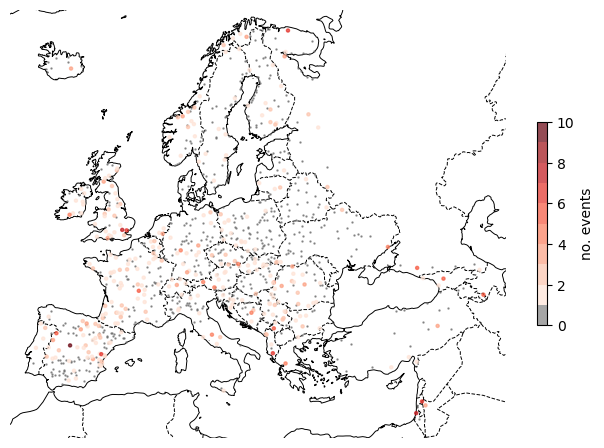

In [41]:
path_reanalysis = '../data/exceedance/reanalysis/'

# load probability of exceeding the discharge threshold in the REANALYSIS data
rean_exc = pd.read_parquet(f'{path_reanalysis}/exceedance_rl5.parquet')
rean_exc.columns = rean_exc.columns.astype(int)
rean_exc = rean_exc.loc[pd.to_datetime(pred.datetime.data), stations.index.tolist()]

# compute onsets of the flood events
rean_onsets = rean_exc.astype(int).diff(axis=0) == 1
rean_onsets.iloc[0,:] = rean_exc.iloc[0,:]

# create a DataArray with the number of observed events per station
n_events_obs = xr.DataArray(rean_onsets.sum(), dims=['id'], coords={'id': rean_onsets.columns.tolist()})
stations['n_events_5'] = n_events_obs.to_pandas()
print('no. events:\t\t\t{0}'.format(n_events_obs.sum().data))
del rean_onsets

# select stations with events
mask_stn = (n_events_obs > 0).to_pandas()
print('no. stations with events:\t{0}'.format(mask_stn.sum()))

# colormap used for the maps
cmap, norm = create_cmap('Reds', np.arange(0, n_events_obs.max(), 1), 'no. events', [0, (.5, .5, .5, .5)])
plot_map_stations(stations.X, stations.Y, n_events_obs.to_pandas(), mask=~mask_stn,
                  cmap=cmap, norm=norm, size=5, figsize=(8, 8),alpha=.7)
plt.colorbar(plot_map_stations.colorbar, shrink=.33, label='no. events')
plt.savefig(f'{path_out}/map_observed_events.png', dpi=300, bbox_inches='tight');

> ***Figure 1**. Number of observed flood events in the selected reporting points.Small gray dots represent points without observed events.*

The number of events has increased after giving priority to reporting points upstream during the selection process. Out of the 900 selected reporting points, 322 suffered a flood event in the last two years, summing up to a total of 526 observed flood events.

##### Reformat data

I convert the reanalysis data into a `xarray.DataArray`, which will be useful in the following steps.

In [42]:
# create a DataArray with observed threshold exceedance
obs = df2da(rean_exc, dims=['id', 'datetime'], plot=False, figsize=(16, 20), title='observed exceendace')
del rean_exc

# expected probability of an exceedance
obs = obs.astype(int)

print(obs.dims)
print(obs.shape)

('id', 'datetime')
(900, 2882)


The following plot is a graphical explanation of the new format in which forecast exceedance probability is stored. 

## 3 Assess skill

In this section I will compute the skill of the EFAS predictions in different ways. In all the following sections I will work with three metrics: recall, precision and the f1-score. The three metrics are based in the contingency table of hits ($TP$ for true positives), false alarms ($FP$ for false positives) and misses ($FN$ for false negatives).

$$recall = \frac{TP}{TP + FN}$$
$$precision = \frac{TP}{TP + FP}$$
$$f1 = \frac{2 \cdot TP}{2 \cdot TP + FN + FP}$$

### 3.2 Where events predicted at any point in time?

The objective of this section is to check if observed events where predicted at all, no matter leadtime.

To convert exceedance probability for each meteo forcing into predicted events we need to come up with a total exceedance probability, i.e., combine the probabilities of each meteo forcing into a single probability value. This total probability will later be compared against a probability threshold to discern events. I will test four different approaches:

* `current`:  the current notification criteria. At least a probabilistic and deterministic model must exceed the probability threshold.
* `model_mean`: a simple mean over the 4 forcings.
* `member_weighted`: a mean weighted by the number of members that each meteo forcing contains. In this approach the probabilistic models, specifically that from ECMWF, prevail.
* `brier_weighted`: a mean weighted by the previously calculated Brier score. This is an approach in between the simple mean and the mean weighted by the number of members. Probabilistic forcings will prevail because they proved to be more skillful, but their relative importance is lower than in the previous approach.

In [ ]:
# # compute predicted events
# pred_events = {label: compute_events(pred_exc, persistence=pers, resample='d', min_leadtime=min_leadtime) for label, pers in persistence.items()}
# pred_events = xr.Dataset(pred_events).to_array(dim='persistence').chunk({'id': 1})
# # convert leadtime in hours to leadtime in days
# pred_events['leadtime'] = np.ceil(pred_events.leadtime / 24).astype(int)

# # calculate number of predicted events
# n_events_pred = count_events(pred_events).compute()

##### Hits, misses and false alarms

In the computation of hits, misses and false alarms I have applied a centered window function of width 5, which allows for a time lag between prediction and observations of 2 timestep (12 h) both before or after the observed events. 

I have also tried an asymmetrical (right-sided) window function of width 3 that allows only for 2-timestep lag (12 h) when the forecast predicts the event sooner than it actually happened. In the posterior skill analysis this approach proved slightly poorer (maximum f1-score of 0.40 instead of 0.51) than when applying the centered window.

Personally, I think that applying a centered window is correct. Since one of the notification criteria states that notifications are only raised for leadtimes larger than 48 h, the fact that the prediction is 12 h delayed will still give, in the worst case, 36 h of notice.

In [99]:
# import NetCDF files of true positives (TP)
files = glob.glob(f'{path_out}TP_persistence*.nc')
persistences = [f.split('_')[-1].split('.')[0].replace('-', '/') for f in files]
TP = xr.Dataset({pers: xr.open_dataarray(file) for pers, file in zip(persistences, files)}).to_array(dim='persistence')
TP.close()

In [100]:
# import NetCDF files of true positives (TP)
files = glob.glob(f'{path_out}FP_persistence*.nc')
persistences = [f.split('_')[-1].split('.')[0].replace('-', '/') for f in files]
FP = xr.Dataset({pers: xr.open_dataarray(file) for pers, file in zip(persistences, files)}).to_array(dim='persistence')
FP.close()

In [101]:
# import NetCDF files of true positives (TP)
files = glob.glob(f'{path_out}FN_persistence*.nc')
persistences = [f.split('_')[-1].split('.')[0].replace('-', '/') for f in files]
FN = xr.Dataset({pers: xr.open_dataarray(file) for pers, file in zip(persistences, files)}).to_array(dim='persistence')
FN.close()

In [102]:
# import NetCDF files of predicted events
files = glob.glob(f'{path_out}/predicted_events*.nc')
persistences = [f.split('_')[-1].split('.')[0].replace('-', '/') for f in files]
n_events_pred = xr.Dataset({persistence: xr.open_dataarray(file) for persistence, file in zip(persistences, files)}).to_array(dim='persistence')
n_events_pred.close()

In [103]:
# compute false negatives (FN) and false positives (FP)
FN = n_events_obs - TP
FP = xr.ufuncs.maximum(0, n_events_pred - TP)

In [104]:
# join TP, FN and FP in a single dataset
dims = ('id', 'persistence', 'approach', 'probability')
hits = xr.Dataset({'TP': TP.transpose(*dims),
                      'FN': FN.transpose(*dims),
                      'FP': FP.transpose(*dims)})

##### Compute skill

In [105]:
# compute skill regardless of leadtime
skill = xr.Dataset({'recall': hits.TP.sum('id') / (hits.TP.sum('id') + hits.FN.sum('id')),
                   'precision': hits.TP.sum('id') / (hits.TP.sum('id') + hits.FP.sum('id')),
                   'f1': 2 * hits.TP.sum('id') / (2 * hits.TP.sum('id') + hits.FP.sum('id') + hits.FN.sum('id'))})

#### 3.2.3 Analyse overall skill

##### Hits, misses and false alarms

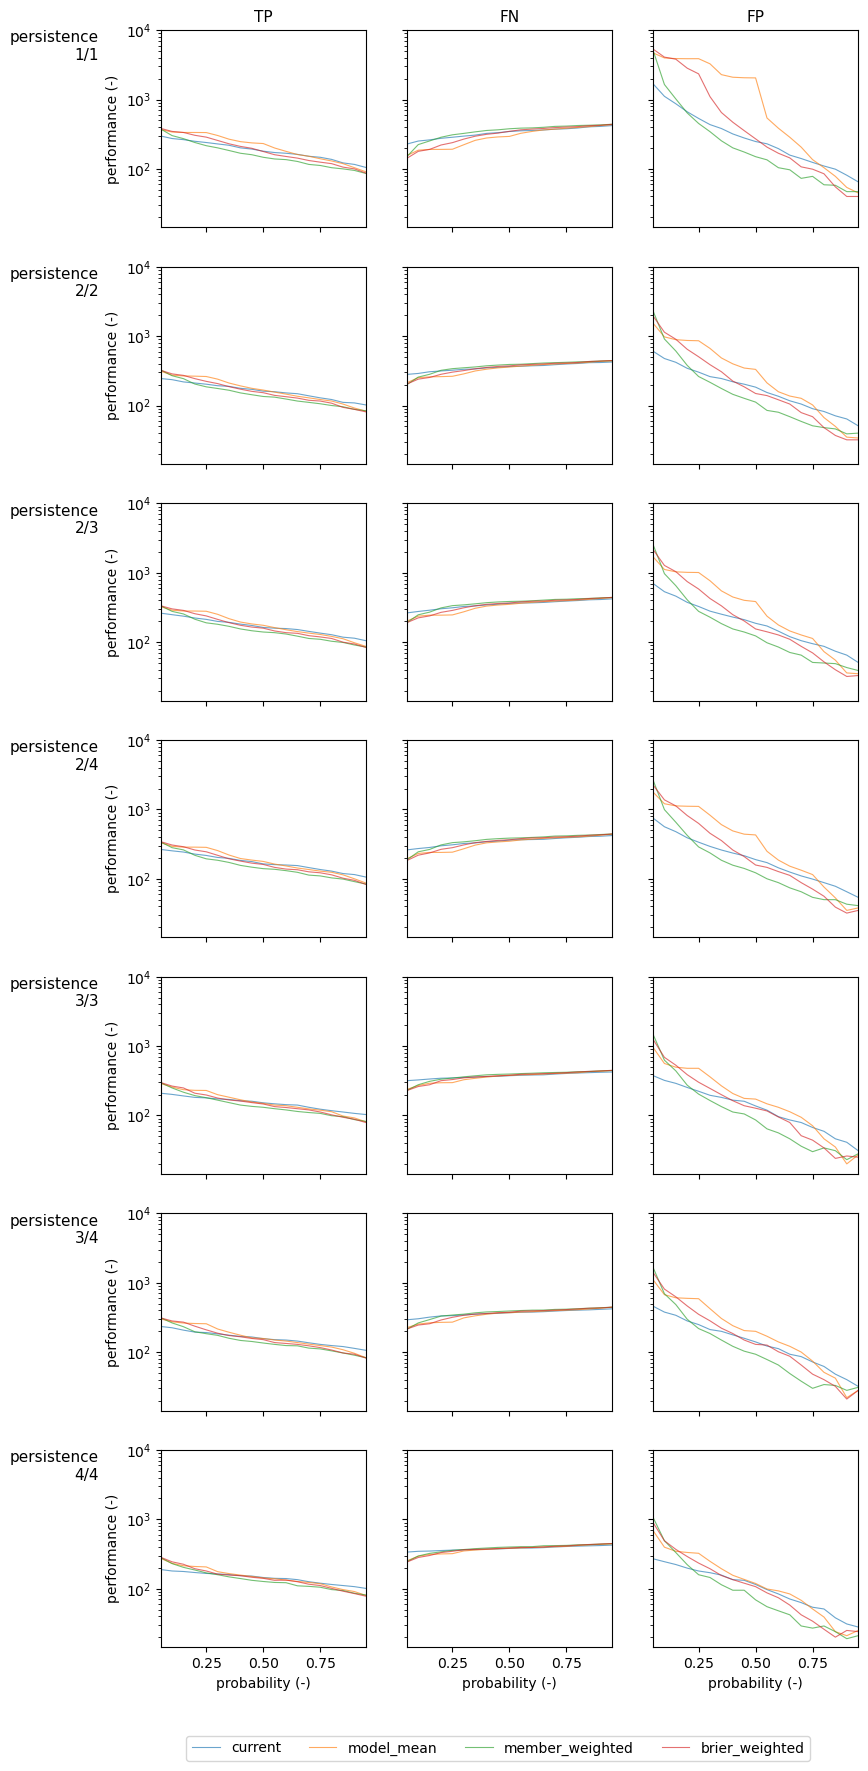

In [106]:
# plot hits, misses and false alarms
lineplot_skill(hits.sum('id'), save=f'{path_out}lineplot_hits.jpg')

Best criteria:
--------------

probability:	0.25
approach:	current
persistence:	2/4

    recall = 0.413
 precision = 0.392
        f1 = 0.402
Best model:
-----------

probability:	0.25
approach:	current
persistence:	2/4

    recall = 0.413
 precision = 0.392
        f1 = 0.402


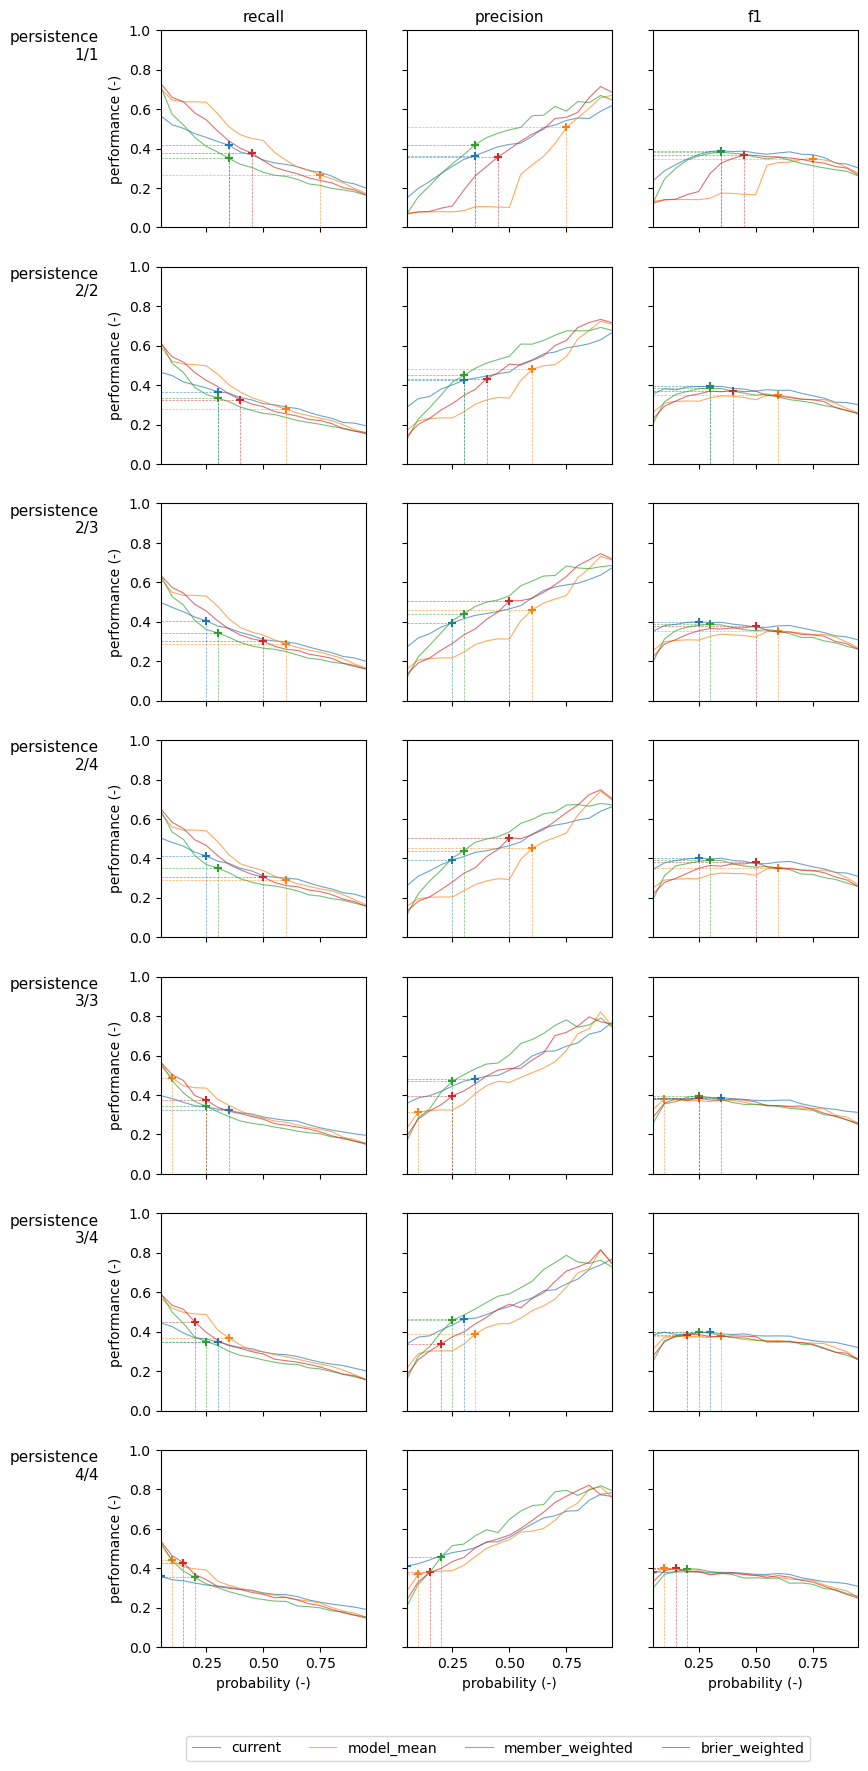

In [107]:
# plot skill metrics
lineplot_skill(skill, bestvar='f1', yscale='linear', round=1, save=f'{path_out}lineplot_skill.jpg')
best_criteria = lineplot_skill.best_criteria

print('Best model:')
print('-----------\n')

for dim in skill.dims:
    print('{0}:\t{1}'.format(dim, skill.sel(best_criteria)[dim].data))

print()
for var in list(skill):
    print('{0:>10} = {1:.3f}'.format(var, skill[var].sel(best_criteria).data))

In [89]:
probs = hits_lt.probability[::3]
ncols, nrows = len(probs), len(hits_lt.persistence)
ig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3 * ncols, 3 * nrows), sharex=True, sharey=True)

agg_metric = skill['f1'].sel(probability=probs).mean('approach')
best_prob = agg_metric.idxmax('probability')
best_metric = agg_metric.max('probability')

for i, pers in enumerate(['1/1', '2/4', '2/3', '2/2', '3/4', '3/3', '4/4']):#hits_lt.persistence.data):
    for j, prob in enumerate(probs.data):
        ax = axes[i,j]
        # ax.set_yscale('log')
        # true positives (FP)
        tp = hits_lt['TP'].sel(probability=prob, persistence=pers).sum('id')
        # total predicted events: TP + FP
        tp_fp = tp + hits_lt['FP'].sel(probability=prob, persistence=pers).sum('id')
        # tp_fp = n_events_pred.sel(probability=prob, persistence=pers).sum('id')
        for k, app in enumerate(hits_lt.approach):
            ax.plot(hits_lt.leadtime, tp.sel(approach=app).data, lw=.8, alpha=.66, c=f'C{k}', label=f'TP ({app.data})')
            ax.plot(hits_lt.leadtime, tp_fp.sel(approach=app).data, lw=.5, ls=':', alpha=.66, c=f'C{k}', label=f'pred ({app.data})')
        # total observed events: TP + FN
        ax.hlines(n_events_obs.sum(), hits_lt.leadtime[0], hits_lt.leadtime[-1], lw=.8, ls='-', color='k', label='obs')
        if i == 0:
            ax.set_title(f'P >= {prob * 100:.0f}%')
        elif i == nrows - 1:
            ax.set_xlabel('leadtime (h)')
            xmin, xmax = hits_lt.leadtime.min(), hits_lt.leadtime.max()
            ax.set(xlim=(xmin, xmax), ylim=(0, None))
            xticks = hits_lt.leadtime[::4]#np.arange(xmin, xmax + 1, 2)
            ax.set_xticks(xticks)
        if j == 0:
            ax.set_ylabel('count (-)')
            ax.text(-.35, 1, f'persistence\n{pers}', fontsize=11, transform=ax.transAxes, verticalalignment='top', horizontalalignment='right')
        if prob == best_prob.sel(persistence=pers):
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set(linewidth=2)
            text = 'f1 = {0:.2f}'.format(best_metric.sel(persistence=pers).data)
            ax.text(.975, .975, text, horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
        
# plt.legend(ax.get_legend_handles_labels(), ncol=3, loc=8);

NameError: name 'hits_lt' is not defined

> ***Figure X**. Hits, misses and false alarms depending on leadtime. Each column represents a pobability threshold and each row a persistence criterion. For each graph, the horizontal black line represents the total number of observed events (526). The colourful, solid lines are the hits for each of the approached used to compute total probability. The distance between the horizontal, black line and the colour, solid lines are the misses. The colourful, dashed lines are the total number of predicted events; the distance between these dashed lines and its respective solid line is the number of false alarms.*

In [ ]:
xdim = 'leadtime'
coldim = 'persistence'
linedim = 'approach'
yscale = 'log'
prob = skill['f1'].mean('approach').idxmax('probability')

ncols = len(hits_lt[coldim])
fig, axes = plt.subplots(ncols=ncols, figsize=(3 * ncols, 2.5), sharex=True, sharey=True)

for j, col in enumerate(['1/1', '2/4', '2/3', '2/2', '3/4', '3/3', '4/4']):#hits_lt[coldim].data):
    ax = axes[j]
    ax.set_yscale(yscale)

    p = prob.sel({coldim: col})
    # true positives (TP)
    tp = hits_lt['TP'].sel({coldim: col, 'probability': p}).sum('id')
    # false positives (FP)
    fp = hits_lt['FP'].sel({coldim: col, 'probability': p}).sum('id')
    for k, line in enumerate(hits_lt[linedim]):
        ax.plot(hits_lt[xdim], tp.sel({linedim: line}).data, ls='-', lw=.8, alpha=.66, c=f'C{k}', label=f'{line.data}: TP')
        ax.plot(hits_lt[xdim], tp.sel({linedim: line}).data + fp.sel({linedim: line}).data, lw=.5, ls=':', alpha=.66, c=f'C{k}', label=f'{line.data}: TP+FP')
    # config
    xmin, xmax = hits_lt[xdim].min(), hits_lt[xdim].max()
    ax.hlines(n_events_obs.sum(), xmin, xmax, lw=.8, ls='-', color='k', label='obs')
    ax.set(xlabel=f'{xdim} (h)', ylabel='count (-)')
    ax.set(xlim=(xmin, xmax))#, ylim=(0, None))
    xticks = hits_lt.leadtime[1::4]
    ax.set_xticks(xticks)
    ax.set_title(f'{coldim} {col}\nP >= {p.data * 100:.0f}%', fontsize=11)

> ***Figure X**. Number of hits, misses and false alarms depending on leadtime. Rows represent different persistence criterion; for each persistence, only the results for the best-performing (in terms of f1) probability threshold are shown. Each solid line corresponds to one of the approached to compute total probability.*

In [92]:
def lineplot_hits(hits, obs=None, xdim='probability', coldim='persistence', rowdim=None, linedim='approach', yscale='linear', xtick_step=4, save=None, **kwargs):
    """
    """
    
    ncols = len(hits[coldim])
    fig, axes = plt.subplots(ncols=ncols, figsize=(3 * ncols, 2.75), sharex=True, sharey=True)
    
    for j, col in enumerate(hits[coldim].data):
        ax = axes[j]
        ax.set_yscale(yscale)
        # true positives (TP)
        tp = hits['TP'].sel({coldim: col}).sum('id')
        # false positives (FP)
        fp = hits['FP'].sel({coldim: col}).sum('id')
        for k, line in enumerate(hits[linedim]):
            ax.plot(hits[xdim], tp.sel({linedim: line}).data, ls='-', lw=.8, alpha=.66, c=f'C{k}', label=f'{line.data}: TP')
            ax.plot(hits[xdim], tp.sel({linedim: line}).data + fp.sel({linedim: line}).data, lw=.5, ls=':', alpha=.66, c=f'C{k}', label=f'{line.data}: TP+FP')
        
        xmin, xmax = hits[xdim].min(), hits[xdim].max()
        if obs is not None:
            ax.hlines(obs, xmin, xmax, lw=.8, ls='-', color='k', label='observed events')
        ax.set_title(f'{coldim} {col}')
        ax.set_xlabel('probability (-)')
        
        ax.set(xlim=(xmin, xmax), ylim=(0, None))
        xticks = hits[xdim][1::xtick_step]
        ax.set_xticks(xticks)
        
        if j == 0:
            ax.set_ylabel('count (-)')
    
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, ncol=len(hits[linedim]) + 1, loc=8, bbox_to_anchor=[.1, -.25, .8, .1])
    
    if save is not None:
        plt.savefig(save, dpi=300, bbox_inches='tight')

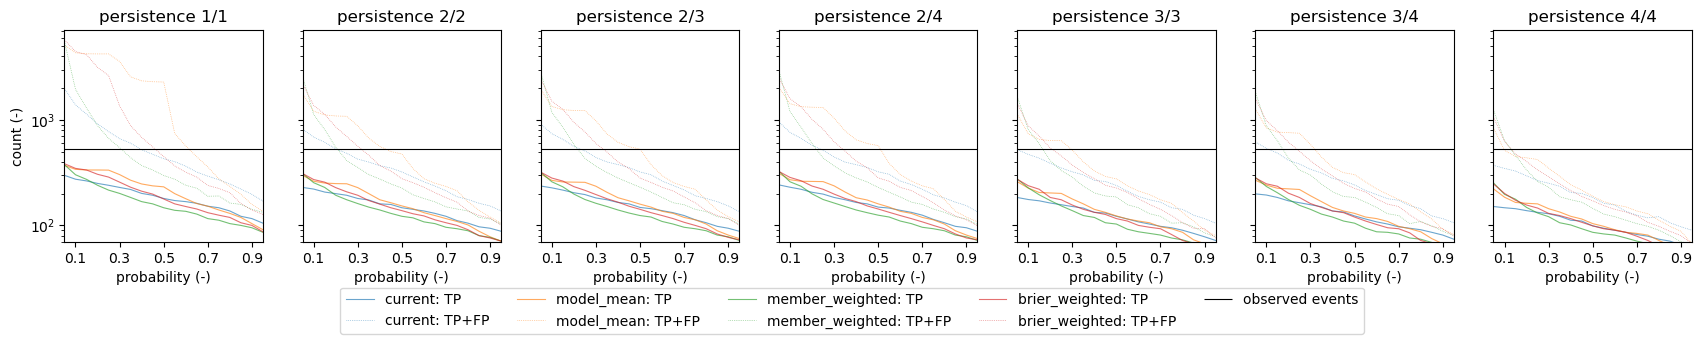

In [96]:
lineplot_hits(hits, obs=n_events_obs.sum().data, yscale='log')

> ***Figure 6**. Counts of true positives (TP), false negatives (FN) and false positives (FP) depending on the probability threshold. Every column in the graph represents a different persistence criterion. The 4 colourful, solid lines in each plot represent the true positives (TP) according to the 4 methods used to compute total probability. The solid, black line is the number of observed events; therefore, the difference between this line and the TP lines accounts for the false negatives. The colourful, dashed likes represent the number of predicted events, i.e., the sum of TP and FP; therefore, the difference bewteen these and the solid lines is the number of FP. The Y axis (counts) is in logarithmic scale because the different order of magnitude of FP compared with TP and FN.*

Insights of the previous figure:

**True positives (TP)**

The number of true positives has a general negative trend with higher probability thresholds. As this threshold increases, we predict less events and, hence, we hit less observed events. This trend is shown for every persistence criterion and approach method. Therefore, the smaller the probability threshold, the higher the TP.

The persistence criterion affects the number of true positives. Stricter criteria generate less predicted events and, hence, less TP.

The spread between approach method is negiglible and constant throughout different persistences.

The maximum value of TP, obtained by the most relaxed probability and persistence criteria, is around 400. This value is approximately 20 % lower than the number of observed events (526), which means that no matter the notification criteria, we can't predict all the events.

**False negatives (FN)**

The analysis of the false negatives is similar to that of true positives, but with an opposite trend regarding the probability criterion. Lower porbability thresholds predict a larger number of events, so fewer observed events will be missed. As we will see later, the effect is the opposite when looking at the false positives; however, the slope of the relation probability-FN is much lower than that of the relation probability-FP. In general, this relation is fairly linear, except for very low probability values.

The persistence criterion has a minor effect on the false negatives, with larger values for stricter persistence values.

**False positives (FP)**

FP is the most sensitive variable, both regarding the probability and the persistence criteria. 

Regarding the probability threshold, the slope of the FP plots is much larger than FP or FN. As we raise the probability threshold, we are more certain that an event will happen when we forecast it, and the number of false positives decreases. The relation between the probability threshold and the number of false positives is fairly linear, except for the approach *member_weighted*. Therefore, the optimal probability threshold will be always very high (if not the maximum) to limit the number of false positives.

Another approach to limit the number of false positives is to add the persistence criterion. When doing away with persistence (top-right plot), FP ranges from a few thousands to a few hundreds depending on the probability threshold. As we apply more restrictive persistence (going down the graph), the amount of FP is reduced drastically to a range between less than a thousand and a few dozens for the most restrictive persistence (bottom-right plot).

FP is also the variable that shows a larger spread among approach methods, even though all the methods show a similar trend. The stricter the persistence criterion, the narrower the spread.
<br>
<br>
> <font color='royalblue'>The most important idea to extract from the previous figure is that **the most sensitive variable is the number of false positives** and that the optimal notification criteria will be the one that minimizes this value without compromising excesively the true positives and false negatives.</font>

##### Skill: recall, precision and f1

In [ ]:


probs = skill_lt.probability[::3]
ncols, nrows = len(probs), len(skill_lt.persistence)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3 * ncols, 3 * nrows), sharex=True, sharey=True)

agg_metric = skill['f1'].sel(probability=probs).mean('approach')
best_prob = agg_metric.idxmax('probability')
best_metric = agg_metric.max('probability')

for i, pers in enumerate(['1/1', '2/4', '2/3', '2/2', '3/4', '3/3', '4/4']):#skill_lt.persistence.data):
    for j, prob in enumerate(probs.data):
        ax = axes[i,j]
        skill_pp = skill_lt.sel(probability=prob, persistence=pers)
        for ls, lw, c, metric in zip(['-', '-', '-'], [.4, .4, .8], ['steelblue', 'firebrick', 'k'], ['recall', 'precision', 'f1']):
            ax.plot(skill_pp.leadtime, skill_pp[metric].transpose(), ls=ls, lw=lw, c=c, alpha=.8, label=metric)
        if i == 0:
            ax.set_title(f'P >= {prob * 100:.0f}%')
        elif i == nrows - 1:
            ax.set_xlabel('leadtime (h)')
            xmin, xmax = skill_pp.leadtime.min(), skill_pp.leadtime.max()
            ax.set(xlim=(xmin, xmax), ylim=(0, 1))
            xticks = hits_lt.leadtime[::4]#np.arange(xmin, xmax + 1, 2)
            ax.set_xticks(xticks)
        if j == 0:
            ax.set_ylabel('performance (-)')
            ax.text(-.3, 1, f'persistence\n{pers}', fontsize=12, transform=ax.transAxes, verticalalignment='top', horizontalalignment='right')
        if prob == best_prob.sel(persistence=pers):
            for axis in ['top','bottom','left','right']:
                ax.spines[axis].set(linewidth=2)
            text = 'f1 = {0:.2f}'.format(best_metric.sel(persistence=pers).data)
            ax.text(.975, .975, text, horizontalalignment='right', verticalalignment='top', transform=ax.transAxes)
    
hndls, lbls = ax.get_legend_handles_labels()
hndls = hndls[::len(skill_lt.approach)]
lbls = lbls[::len(skill_lt.approach)]
fig.legend(hndls, lbls, bbox_to_anchor=[0., -.02, .5, .1], ncol=len(skill_lt));

In [ ]:
ncols = len(skill_lt.persistence) - 1
ig, axes = plt.subplots(ncols=ncols, figsize=(3 * ncols, 3), sharex=True, sharey=True)

var = 'recall'
# prob_1 = skill_lt[var].sel(persistence='1/1').mean('approach').max('leadtime').idxmax('probability')
prob_1 = skill['f1'].sel(persistence='1/1').mean('approach').idxmax('probability')
skill_1 = skill_lt[var].sel(probability=prob_1, persistence='1/1').transpose()
print(prob_1.data)
prob = skill['f1'].mean('approach').idxmax('probability')
for j, pers in enumerate(['2/4', '2/3', '2/2', '3/4', '3/3', '4/4']):
    ax = axes[j]
    p = prob.sel(persistence=pers)
    ax.plot(skill_lt.leadtime, skill_lt[var].sel(probability=p, persistence=pers).transpose().data, c='firebrick', lw=.8, alpha=.66)
    ax.plot(skill_lt.leadtime, skill_1, c='k', lw=.8, alpha=.66, zorder=0)
    ax.set_title(f'persistence {pers}')
    ax.set_xlabel('leadtime (h)')
    xmin, xmax = skill_lt.leadtime.min(), skill_lt.leadtime.max()
    ax.set(xlim=(xmin, xmax), ylim=(0, 1))
    xticks = hits_lt.leadtime[::4]#np.arange(xmin, xmax + 1, 2)
    ax.set_xticks(xticks)
    if j == 0:
        ax.set_ylabel(f'{var} (-)')
    text = f'P >= {p.data * 100:.0f}%'
    ax.text(.975, .975, text, fontsize=10, verticalalignment='top', horizontalalignment='right', transform=ax.transAxes)

> ***Figure X**. Performance evolucion regarding leadtime. Every graph represents a combination of a persistence and a probability criteria; columns represent increasing probability threshold, and rows incresin persistence. For each graph, blach lines represent f1 score, the harmonic mean of recall (blue lines) and precision (red lines); every metric has 4 lines correspoding to the methods used to compute total probability.*

In [ ]:
ds = skill

# plot skill metrics
lineplot_skill(ds, rowdim='persistence', bestvar='f1', yscale='linear', round=1, )#save=f'{path_out}skill_eventwise_(all_stations).jpg')
best_criteria = lineplot_skill.best_criteria

> ***Figure 7**. EFAS skill predicting flood events in terms of $recall$, $precision$ and $f1$. Every plot shows the variability of the skill metric depending on the probability threshold for the 4 methods used to compute total probability. Every row represents a different persistence criterion, with stricter persistence as we go down the figure. Crosses represent the probability that optimizes $f1$ for that specific persistence and approach method; the same probability is used for the $recall$, $precision$ and $f1$ plots.*

In [ ]:
ds = skill_lt.isel(leadtime=slice(1, None, 2)).sel(persistence=best_criteria['persistence'])

# plot skill metrics
lineplot_skill(ds, rowdim='leadtime', bestvar='f1', yscale='linear', round=1, )#save=f'{path_out}skill_eventwise_(all_stations).jpg')

**Recall**

As expected, both $recall$ and $precision$ show monotic and opposite trends along the probability axes. $Recall$ decreases with higher probability thresholds, since the number of true positives is maximized and the number of false negatives minimized (see Figure X). This trend is mostly linear, but for the lowest probability thresholds, and similar over approach methods and persistence criteria. 

**Precision**

On the contrary, $precision$ increases with higher probability, which means that the reduction of false positives prevails over a smaller reduction in false positives (see Figure X). The behabiour of presicion is more erratic both in terms of persistence and approach method, so we can't specify a general trend. The best example of this erratic behaviour is the plot for persistence 1 (no persistence), where every model behaves differently; some seem to have an asintotic behaviour (_current_, *member_weighted*), whereas the others are insentive for lower probabilities and then increase dramatically.

**f1**

Before getting into details, a reminder that $f1$ is the harmonic mean of $recall$ and $precision$, being a proper metric to combine the other two metrics in unbalanced problems such as this one.

Luckily, $f1$ does not have a monotonic behaviour, which would cause that the optimal probability threshold would be either very low or very large. Instead, we can see two different behaviours depending on the persistence criterion. On the one hand, the more relax persistence criteria (1/1, 2/2 and 2/4) show an asymptotic behaviour, i.e., from a certain probability onwards, the f1 score is basically constant. On the other hand, the stricter persistence critera (3/3, 3/4 and 4/4) show a wide plateau over which f1 is constant, but the skill worsens for very large probability thresholds. Interestingly, the f1 score of this plateau/asymptote is the same (or almost the same) for every approach method; the difference between methods is the probability threshold at which the plateau is reached and at which f1 peaks. Therefore, the method used to compute the total probability is not determining the overall skill.

Persistence affects the results in two ways. First, it defines the f1 score of the plateau/asymptote. The highest f1 score (0.46) is reached for persistence 2/4, but other persistence criteria have close results. However, very strict criteria (3/3, 3/4 and 4/4) reduce the skill to values closer to 0.40. Second, persistence affects the optimal probability threshold. There seems to be a trade-off between persistence and probability, in a sense that relaxed persistence requires higher probability thresholds, whereas strict persistence allows for smaller probability thresholds. The highest f1 score (0.46) is reached for a probability threshold of 50%.

> <font color='royalblue'>From these results we can extract that **$f1$ can be optimised in terms of persistence and probability threshold**. The approach used to compute total probability, however, does not affect the maximum $f1$ score. There's a **trade-off between persistence and probability**, since together they must constrain the amount of false positives, hence, improve $precision$ and $f1$. **The highest performing combination of criteria is that with a probability threshold of 50%, a persistence of 2 out of 4 forecast, and for which total probability was computed using the Brier score as a weighing factor**.</font>

#### 3.2.4 Anaylse skill by reporting points

##### Hits, misses and false alarms

In [ ]:
# extract the hits, misses and false alarm for each station based on the best criteria
hits_stn = hits.isel(best_model)
for var, da in hits_stn.items():
    # convert xr.DataArray to pd.Series
    stations[title] = da.to_pandas()

map_hits(stations, cols=['TP', 'FN', 'FP'], mask=mask_stn,
         save=f'{path_out}hits_eventwise_maps_reporting_points.jpg')

> ***Figure 8**. Maps of hits, misses and false alarms for each reporting point with the best performing criteria. The colour scale changes depending on the variable with the rational that red (darker red) means worse values, whereas blue (darker blue) better values. In the case of hits (TP) and misses (FN) a mask has been applied to remove reporting points with no observed events (gray points), since none of these variables make sense if there are no observations to predict or miss.*

The figure above shows the number of hits (TP), misses (FN) and false alarms (FP) by reporting point for the best-performing criteria. Red colours represent bad behaviour, whereas blue colours good behabiour.

**Hits (TP)**

The reporting points shown in this plot are only those with at least one observed event (the rest are "masked" and shown with gray points). The number of reporting points with at least one observed event is 322; from those, the model didn't predict any event in more than a half (178). If we look at the total amount of events, less than a half of the observed events were correctly predicted (213/526). There doesn't seem to be a clear geographic pattern neither for the bad nor the good performing points.

**Misses (FN)**

As in the previous case, this plot only shows points with observed events (322). Out of these reporting points, approximately a third had no misses. In total, more than half of the events were missed (313 out of 526).

**False alarms (FP)**

The best criteria would raise 188 false alarms in 125 reporting points. Some points would report as many as 7 false alarm, which may be an indicator of a specific problem in the hydrological simulation of those points.

In [ ]:
# station with higher amount of misses
stations.loc[stations.FN > 4].sort_values('FN', ascending=False)

In [ ]:
# stations with a higher amount of false alarms
stations.loc[stations.FP > 2].sort_values('FP', ascending=False)

##### Skill: recall, precision and f1

In [ ]:
# compute metrics
stations['recall'] = stations.TP / (stations.TP + stations.FN)
stations['precision'] = stations.TP / (stations.TP + stations.FP)
stations['f1'] = 2 * stations.TP / (2 * stations.TP + stations.FN + stations.FP)

map_skill(stations, cols=['recall', 'precision', 'f1'], bins=50, cmap=cmap_f1, norm=norm_f1,
          save=f'{path_out}skill_eventwise_maps_reporting_points.jpg')

> ***Figure 9**. EFAS skill (in terms of recall, precision and f1) disaggregated by reporting points. Gray dots represent reporting points for which the metric cannot be calculated (division 0 by 0); these points vary from one metric to another. The texts at the bottom show the number of zeros or ones in the metric out of the number of reporting points for which it was possible to compute the metric.*

For the majority of reporting points the metrics can't be computed. The numberr of reported points is 900, whereas the metric with more values (f1) could only be computed for 388 stations. This means that when analysing the results by reporting points, almost two third of them are discarded.

The histograms at the bottom show the distribution of the metric values. In all three metrics the results are polarised, with most of the points having either a metric value of 0 or 1.

**Recall**

Recall could be computed for the 322 stations that have observed events. Out of those, in more than a half (178) none of the observed events were detected (recall = 0). On the contrary, in a third of the stations all the events were detected (recall = 1). 

**Precision**

Precistion could be computed in less reporting points than recall (234 out of 900). Approximately in half of the points (109) all the predicted events were correct (precision = 1), whereas in another half (90) none of the predicted events were right (precision = 0)

**f1**

F1 could be computed in more points than the previous two metrics (388 out of 900). However, it's the metric with worse results. Approximately two thirds (244 out of 388) of the points show now skill (f1 = 0), and only a fifth (81 out of 388) a perfect skill (f1 = 1).


##### Precision-recall curve

In [ ]:
skill_persistence = skill.sel(persistence='2/4')

In [ ]:
lab = 'model_mean'

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

for label in skill.approach.data:
    ax.plot(skill.sel(persistence='2/4', approach=label).recall.data,
            skill.sel(persistence='2/4', approach=label).precision.data,
            label=label)
ax.set(xlim=(0, 1), ylim=(0, 1), xlabel='recall', ylabel='precision', title='precision-recall curve') 
ax.set_aspect('equal')
ax.legend(loc=0);

***

In [ ]:
pred_events